# Going Deeper CV-10: U-Net and U-Net++
*  Semantic Segmentation(시맨틱 세그멘테이션) 을 이용해서 자율주행차량이 주행해야 할 도로 영역을 찾는 상황을 가정하고 모델을 만들어본다
* 입력된 이미지에 대해 U-Net을 이용하여 도로의 영역을 Segmentation하고, U-Net++과의 성능 차이를 비교한다

#### 루브릭:
1. **U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?**  KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.
2. **U-Net++ 모델이 성공적으로 구현되었는가?** U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.

3. **U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?** U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.

  
#### 실습 목표:
* 시맨틱 세그멘테이션 데이터셋을 전처리할 수 있습니다.
* 시맨틱 세그멘테이션 모델을 만들고 학습할 수 있습니다.
* 시맨틱 세그멘테이션 모델의 결과를 시각화할 수 있습니다.

## 라이브러리 불러오기

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import * 

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

## 데이터셋 준비

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/Aiffel/semantic_segmentation

/content/drive/MyDrive/Aiffel/semantic_segmentation


In [4]:
#pwd

In [5]:
#!wget https://www.dropbox.com/s/thhq5312hdwo494/KITTI.zip

In [6]:
#!unzip KITTI.zip

## 데이터 로더 만들기

In [7]:
def build_augmentation(is_train=True):
  if is_train:   
    return Compose([
                    HorizontalFlip(p=0.5),   
                    RandomSizedCrop(         
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(      
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      
                Resize(
                    width=224,
                    height=224
                    )
                ])

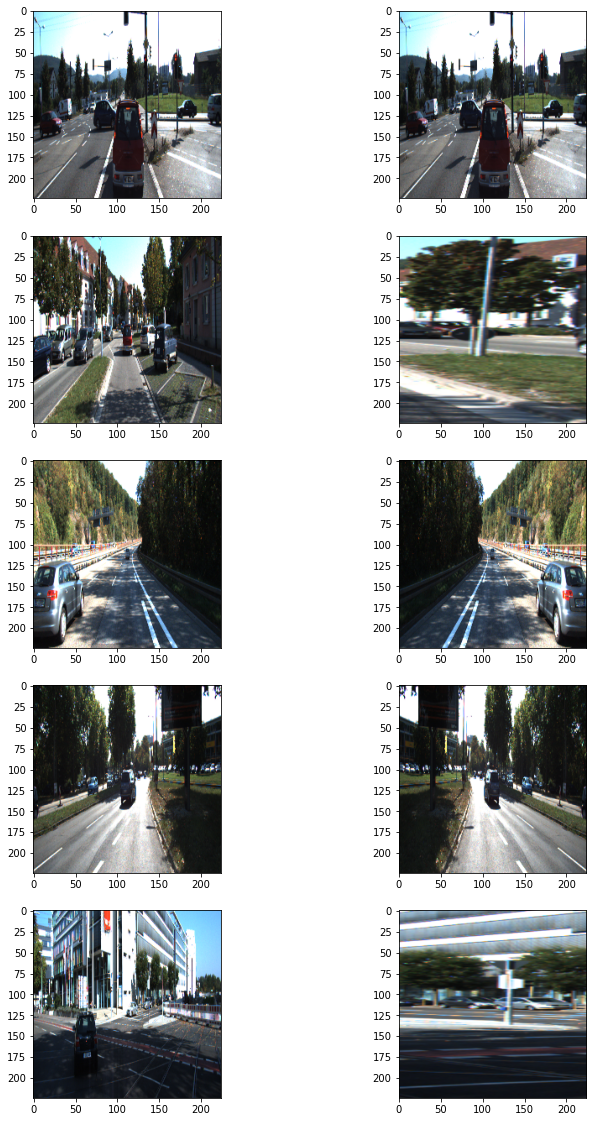

In [8]:
dir_path = '/content/drive/MyDrive/Aiffel/semantic_segmentation/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))


plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"]) 
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  
  
plt.show()

In [9]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    self.data = self.load_dataset()

  def load_dataset(self):
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [10]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## U-Net 모델 만들기

In [11]:
def build_model(input_shape=(224, 224, 3)):

    inputs = Input(input_shape)
	
    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
    
    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

## U-Net 모델 학습

In [12]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [13]:
model_path = '/content/drive/MyDrive/Aiffel/semantic_segmentation/seg_model_unet.h5'


model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 12s 358ms/step - loss: 0.6917 - val_loss: 0.6873
Epoch 2/100
11/11 [==============================] - 4s 327ms/step - loss: 0.6789 - val_loss: 0.6592
Epoch 3/100
11/11 [==============================] - 4s 327ms/step - loss: 0.3238 - val_loss: 0.0301
Epoch 4/100
11/11 [==============================] - 4s 326ms/step - loss: 0.0319 - val_loss: 0.0294
Epoch 5/100
11/11 [==============================] - 4s 328ms/step - loss: 0.0313 - val_loss: 0.0367
Epoch 6/100
11/11 [==============================] - 4s 326ms/step - loss: 0.0322 - val_loss: 0.0322
Epoch 7/100
11/11 [==============================] - 4s 328ms/step - loss: 0.0355 - val_loss: 0.0337
Epoch 8/100
11/11 [==============================] - 4s 328ms/step - loss: 0.0280 - val_loss: 0.0277
Epoch 9/100
11/11 [==============================] - 4s 329ms/step - loss: 0.0346 - val_loss: 0.0361
Epoch 10/100
11/11 [==============================] - 4s 327ms/step - loss: 0.0358 - val_l

## U-Net++ 구현
U-Net++의 메모리 사용량이 U-Net보다 월등히 크기 때문에 batch size를 줄여서 데이터셋을 다시 로딩해준다. 

In [14]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
    batch_size=4
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False,
    batch_size=4
)

In [15]:
def UNetPlusPlus(input_shape=(224,224,3)):

    inputs = Input(input_shape)
    
    # x0,0
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_0)
    pool0_0 = MaxPooling2D(pool_size=(2, 2))(conv0_0)
    # x1,0
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool0_0)
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_0)
    pool1_0 = MaxPooling2D(pool_size=(2, 2))(conv1_0)
    # x2,0
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1_0)
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_0)
    pool2_0 = MaxPooling2D(pool_size=(2, 2))(conv2_0)
    # x3,0
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2_0)
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_0)
    pool3_0 = MaxPooling2D(pool_size=(2, 2))(conv3_0)
    # x4,0
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3_0)  
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4_0)

    # x0,1
    up1_0 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_0)) 
    merge0_1 = concatenate([up1_0, conv0_0], axis = 3)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_1)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_1)
    # x1,1
    up2_0 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_0))
    merge1_1 = concatenate([up2_0, conv1_0], axis = 3)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_1)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_1)
    # x2,1
    up3_0 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_0))
    merge2_1 = concatenate([up3_0, conv2_0], axis = 3)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_1)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_1)
    # x3,1
    up4_0 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4_0))
    merge3_1 = concatenate([up4_0, conv3_0], axis = 3)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_1)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_1)  
    
    # x0,2
    up1_1 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_1)) 
    merge0_2 = concatenate([up1_1, conv0_0, conv0_1], axis = 3)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_2)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_2)
    # x1,2
    up2_1 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_1))
    merge1_2 = concatenate([up2_1, conv1_0, conv1_0], axis = 3)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_2)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_2)
    # x2,2
    up3_1 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_1))
    merge2_2 = concatenate([up3_1, conv2_0, conv2_1], axis = 3)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_2)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_2)

    # x0,3
    up1_2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_2)) 
    merge0_3 = concatenate([up1_2, conv0_0, conv0_1, conv0_2], axis = 3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_3)
    # x1,3
    up2_2 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2))
    merge1_3 = concatenate([up2_2, conv1_0, conv1_1, conv1_2], axis = 3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_3)
    
    # x0,4
    up1_3 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_3)) 
    merge0_4 = concatenate([up1_3, conv0_0, conv0_1, conv0_2, conv0_3], axis = 3)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_4)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_4)
    
    output = Conv2D(1, 1, activation='sigmoid')(conv0_4)
    model = Model(inputs = inputs, outputs = output)
    
    return model
    

In [16]:
plus_model = UNetPlusPlus()
plus_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 224, 224, 64  36928       ['conv2d_20[0][0]']              
                                )                                                           

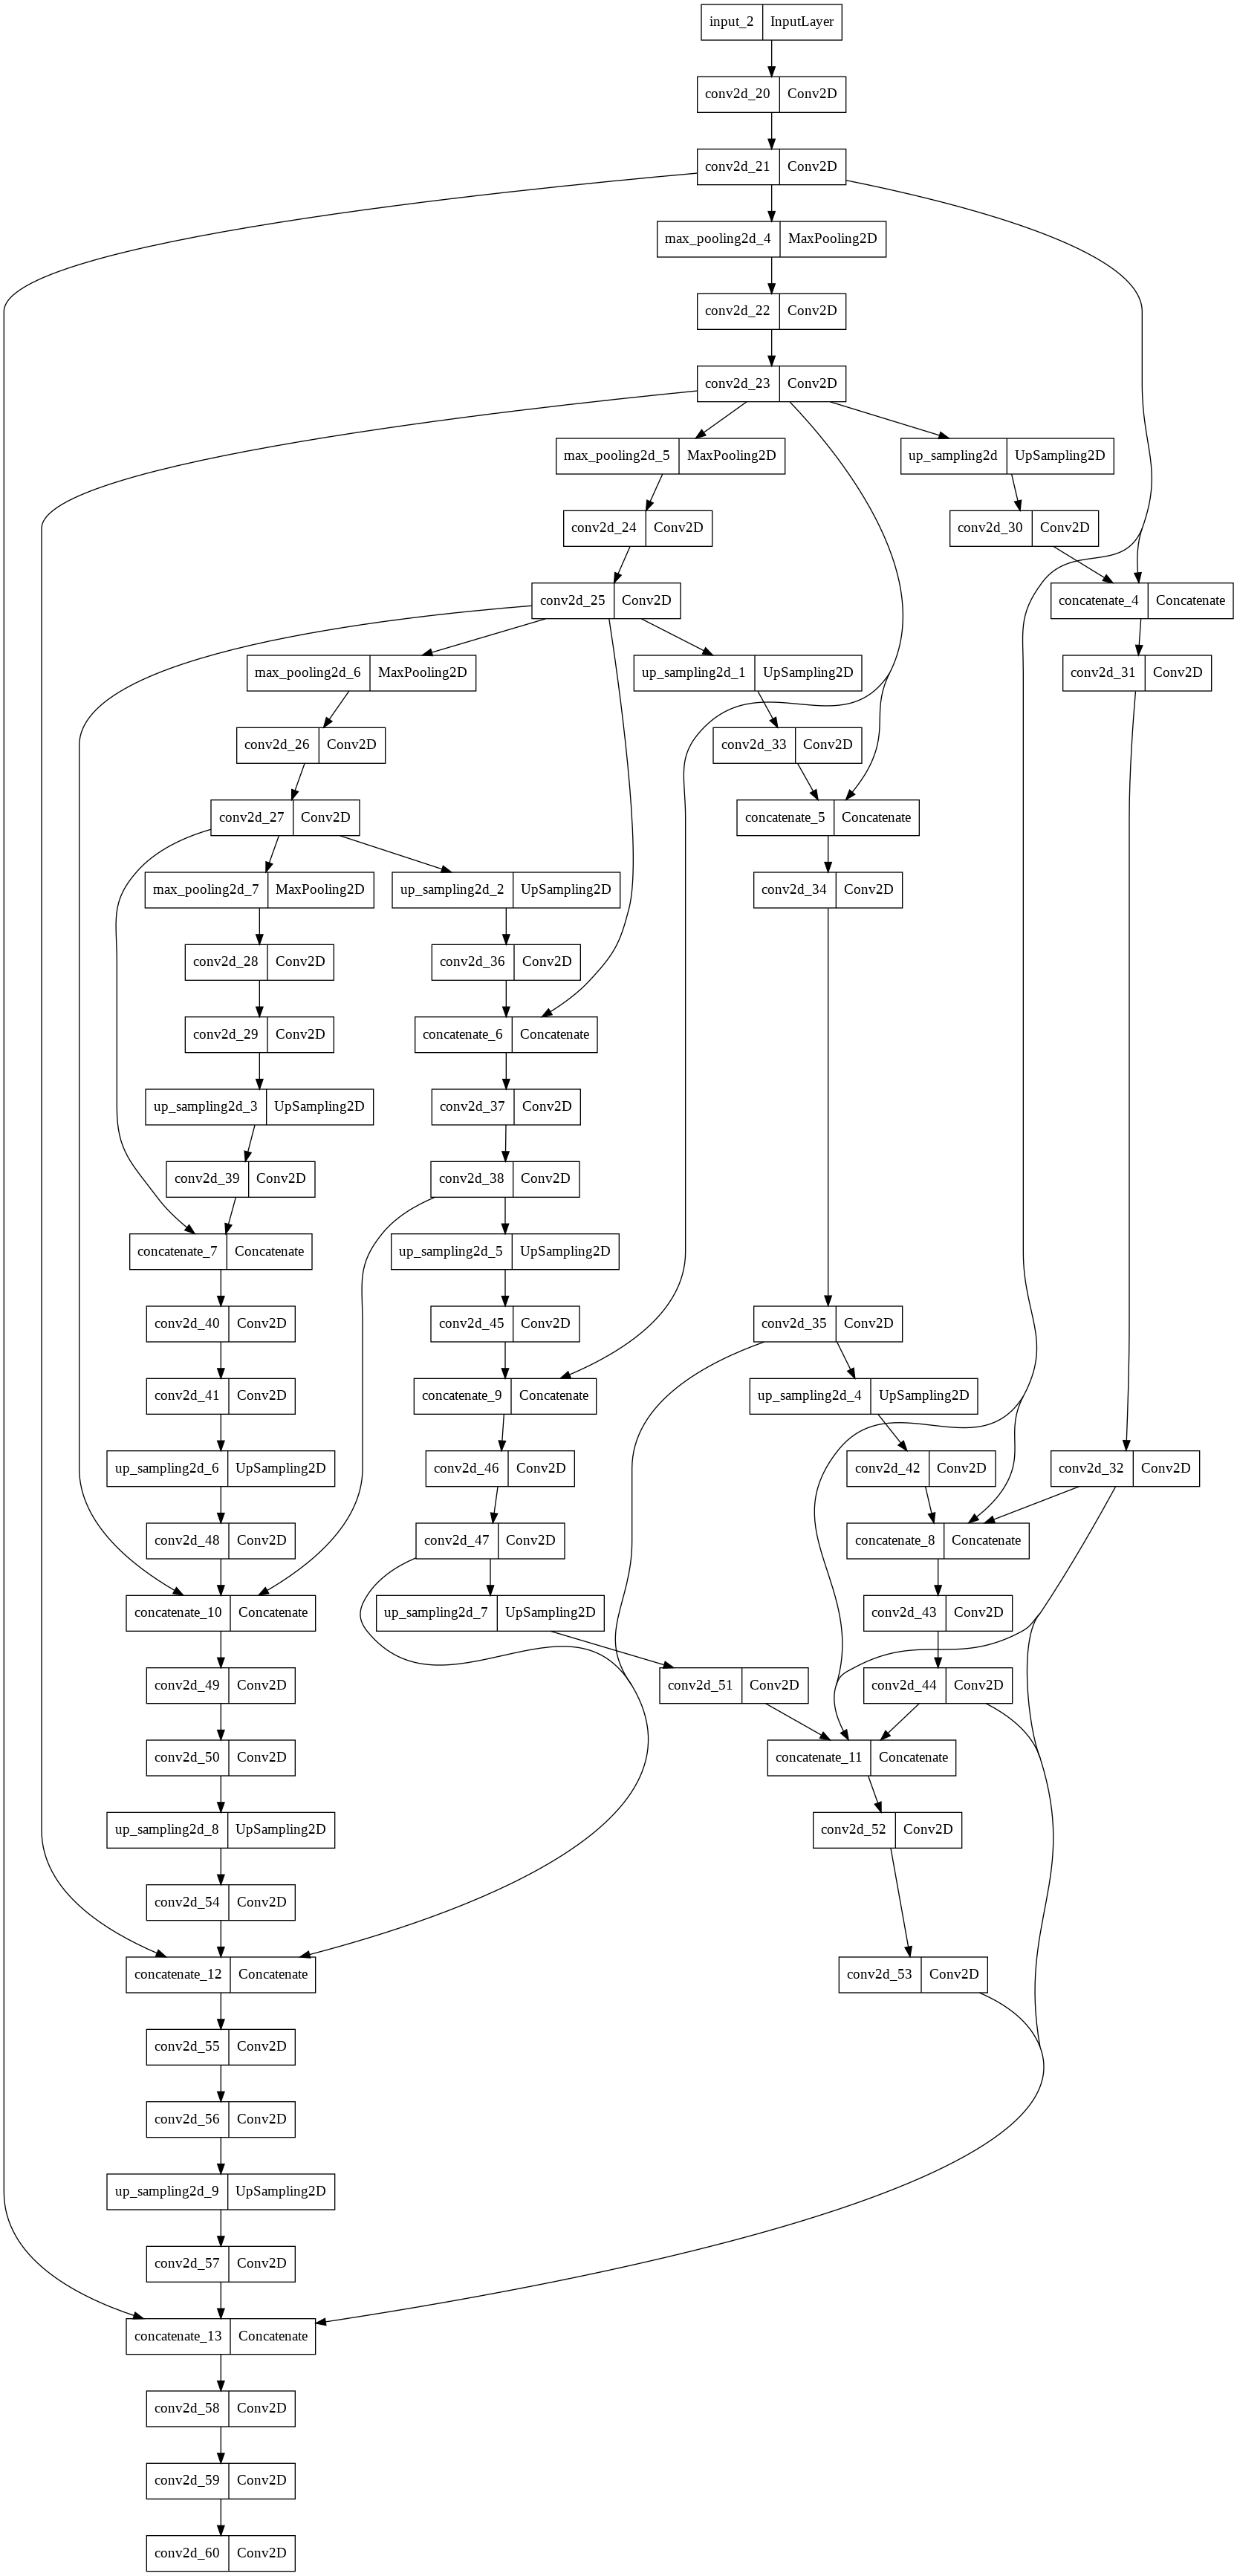

In [17]:
tf.keras.utils.plot_model(plus_model, to_file='./plus_model.png')

In [18]:
plus_model_path = '/content/drive/MyDrive/Aiffel/semantic_segmentation/seg_model_unetpp.h5'

#model = build_model()
plus_model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
plus_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(plus_model_path)  

Epoch 1/100
43/43 [==============================] - 19s 338ms/step - loss: 0.4075 - val_loss: 0.1036
Epoch 2/100
43/43 [==============================] - 14s 328ms/step - loss: 0.1014 - val_loss: 0.0829
Epoch 3/100
43/43 [==============================] - 14s 328ms/step - loss: 0.0993 - val_loss: 0.0840
Epoch 4/100
43/43 [==============================] - 14s 328ms/step - loss: 0.0731 - val_loss: 0.0725
Epoch 5/100
43/43 [==============================] - 14s 328ms/step - loss: 0.0642 - val_loss: 0.0657
Epoch 6/100
43/43 [==============================] - 14s 327ms/step - loss: 0.0602 - val_loss: 0.0542
Epoch 7/100
43/43 [==============================] - 14s 328ms/step - loss: 0.0503 - val_loss: 0.0731
Epoch 8/100
43/43 [==============================] - 14s 328ms/step - loss: 0.0544 - val_loss: 0.0598
Epoch 9/100
43/43 [==============================] - 14s 328ms/step - loss: 0.0524 - val_loss: 0.0670
Epoch 10/100
43/43 [==============================] - 14s 328ms/step - loss: 0.047

## U-Net, U-Net++ 결과 시각화
이미지와 라벨을 한번에 볼 수 있도록 overlay를 해준다. 또한, IoU를 계산하여 모델을 평가까지 해주도록 한다. 

In [19]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    #print('IoU : %f' % iou_score )
    return iou_score

In [20]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

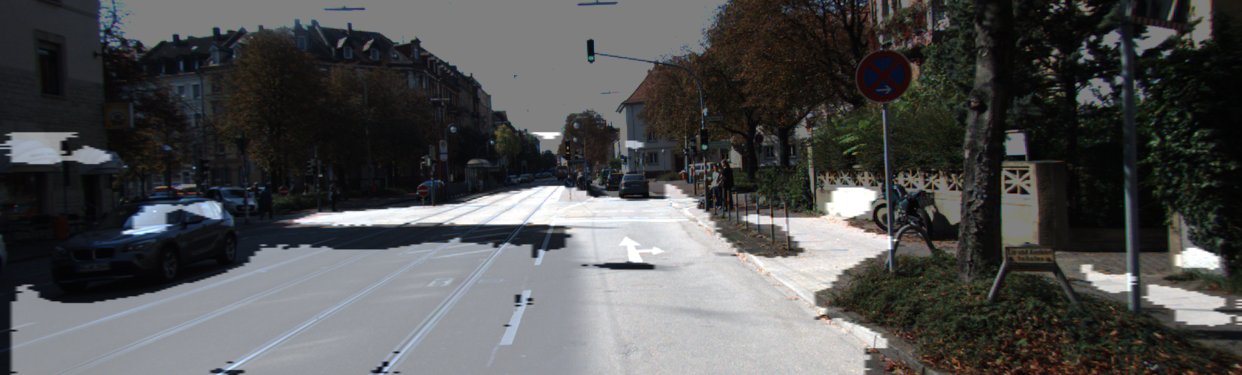

In [21]:
i = 1  
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

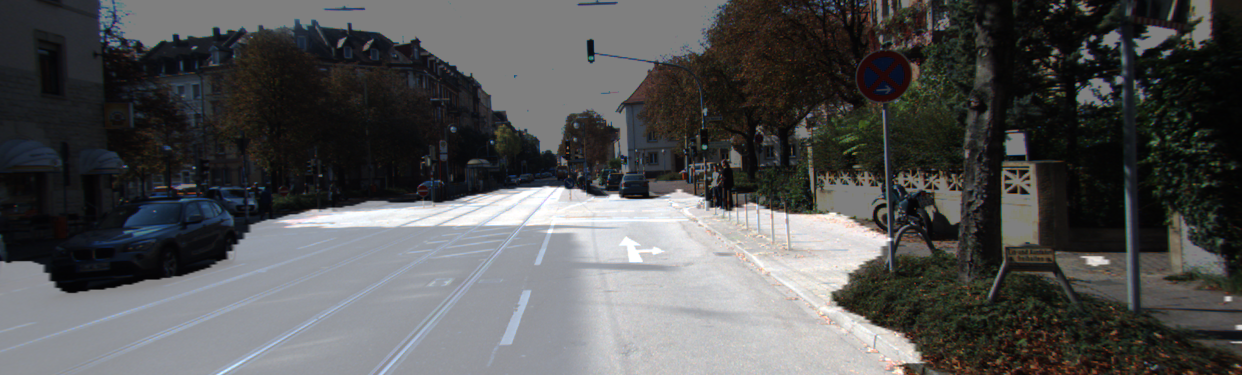

In [22]:
i = 1   
get_output(
     plus_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

#### IoU 계산

In [23]:
def get_output(model, preproc, image_path, output_path, label_path):
    
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255 
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()  
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   

        return output, prediction, target
    else:
        return output, prediction, _

In [24]:
i = 1    
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

print(f"IoU: {calculate_iou_score(target, prediction)}", )

IoU: 0.7590698308783416


In [25]:
i = 1    
output, prediction, target = get_output(
     plus_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

print(f"IoU: {calculate_iou_score(target, prediction)}", )

IoU: 0.8651274982770503


#### 여러 사례 시각화 + IoU 계산

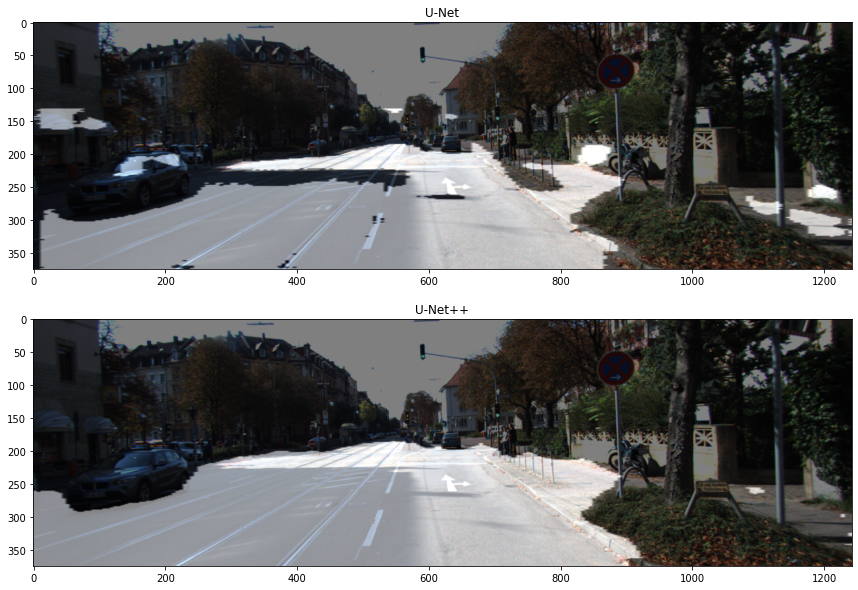

U-Net
IoU: 0.7590698308783416
U-Net++
IoU: 0.8651274982770503
------------------------------------------------------


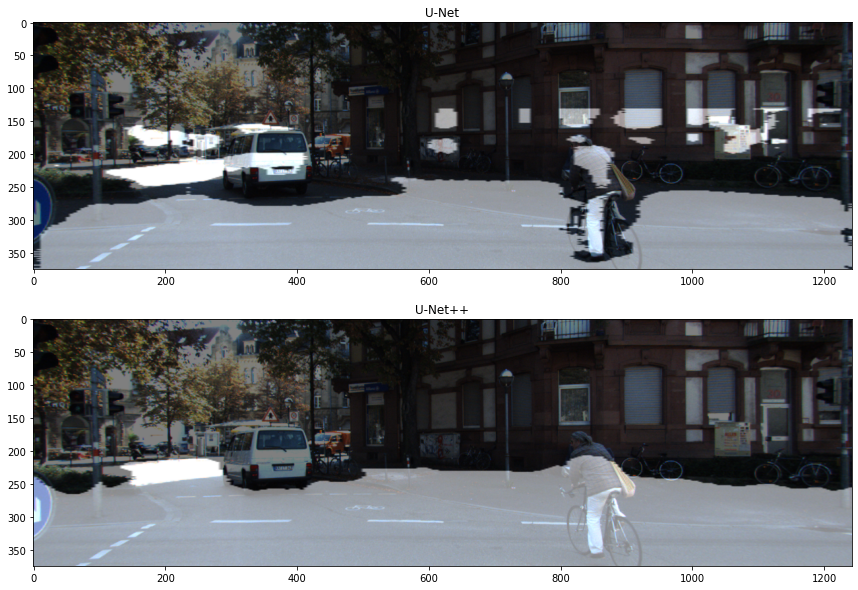

U-Net
IoU: 0.5802578923966207
U-Net++
IoU: 0.6070409646336868
------------------------------------------------------


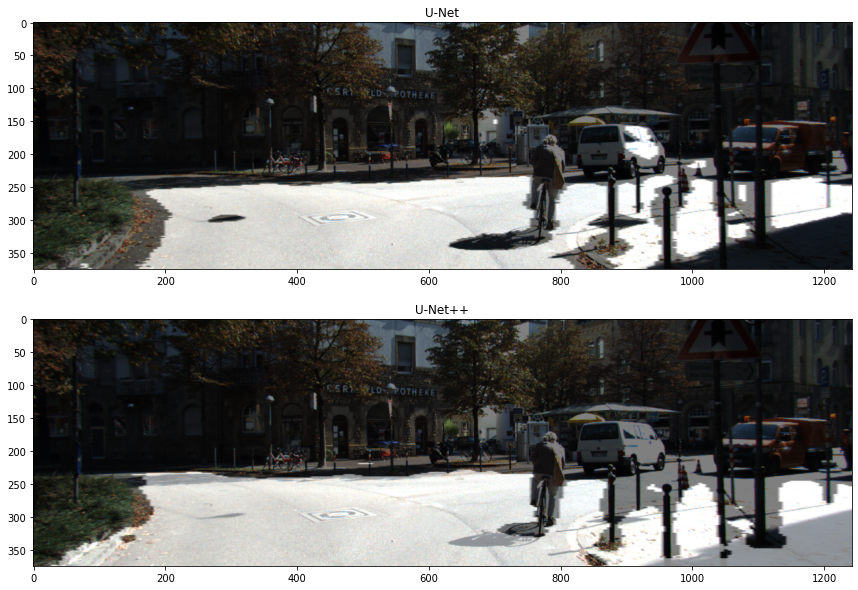

U-Net
IoU: 0.6454729274320378
U-Net++
IoU: 0.6450640037530997
------------------------------------------------------


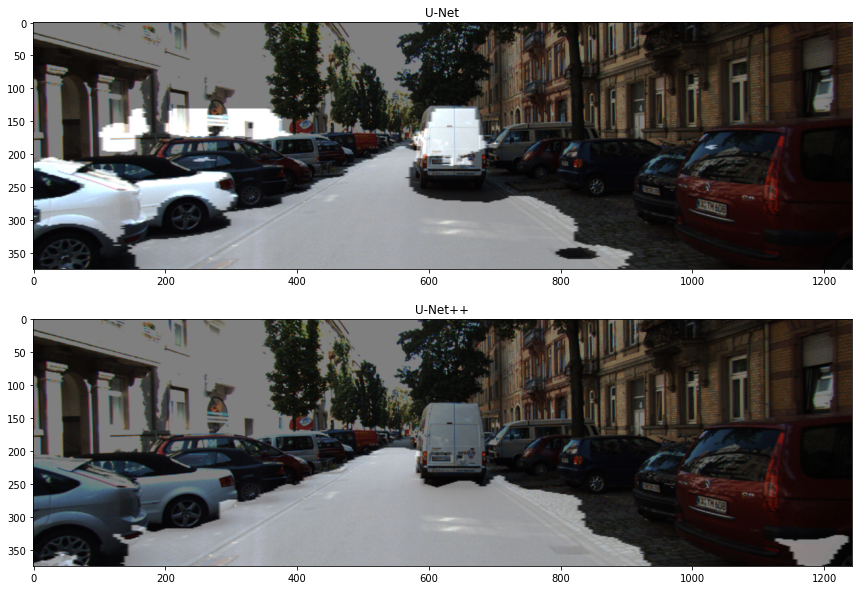

U-Net
IoU: 0.5107718405428329
U-Net++
IoU: 0.6679213718109578
------------------------------------------------------


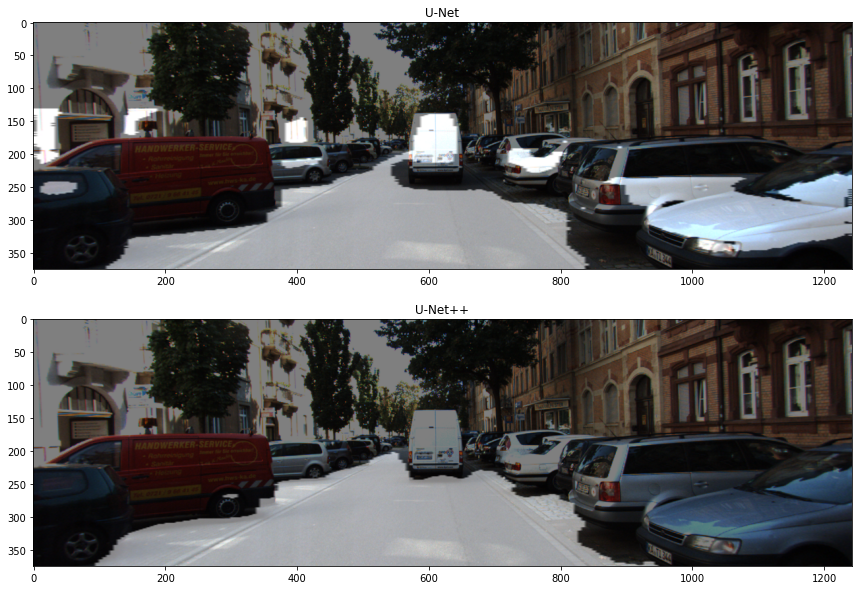

U-Net
IoU: 0.48295266468056935
U-Net++
IoU: 0.6960018382352942
------------------------------------------------------


In [26]:
for i in range(1,6):
    # U-Net
    output1, prediction1, target1 = get_output(
        model, 
        test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
    )
    # U-Net++
    output2, prediction2, target2 = get_output(
        plus_model, 
        test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
    )
    plt.figure(figsize=(20,10))
    plt.subplot(2, 1, 1)
    plt.imshow(output1)
    plt.axis=('off')
    plt.title(f"U-Net") 

    plt.subplot(2, 1, 2)
    plt.imshow(output2)
    plt.axis=('off')
    plt.title(f"U-Net++")

    plt.show()
    print("U-Net")
    print(f"IoU: {calculate_iou_score(target1, prediction1)}", )
    print("U-Net++")
    print(f"IoU: {calculate_iou_score(target2, prediction2)}", )
    print("------------------------------------------------------")


# 회고

* 이번 노드는 U-Net++를 직접 구성하는게 핵심이었는데, 굉장히 어려웠다. ResNet 때도 느꼈지만, skip connection이 있는 모델은 구현하기 아직은 좀 까다로운 느낌이 있다
* 역시나 skip connection이 있는 모델은 없는 모델보다 성능이 뛰어나다는 것을 확실하게 느낄 수 있었다
* 모델의 학습 시간이 파라미터에 비해 오래 걸리지 않는 것이 신기했다. 노드에서는 오래 걸릴거라고 겁 주길래 학습시키기 조심스러웠는데, 의외로 빠르게 학습이 진행되어서 별 탈 없이 노드를 무사히 마칠 수 있었다. 